In [1]:
import rosbag
import csv
import math

# Specify the bag file and output CSV file
#bag = rosbag.Bag('rolldynamics.bag')
#bag = rosbag.Bag('sytemid3_2025-01-22-18-43-57.bag')


#for chirp signal
bag = rosbag.Bag('system_id_sin_wave_2025-02-21-18-02-36.bag')
output_file = 'systemid.csv'

with open(output_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['time', 'roll_cmd', 'roll_actual', 'pitch_cmd', 'pitch_actual'])  # Column headers

    roll_cmd = None
    pitch_cmd = None

    for topic, msg, t in bag.read_messages(topics=['/mavros/setpoint_raw/attitude', '/mavros/local_position/pose']):
        print(f"Reading topic: {topic} at time: {t.to_sec()}")  # Debug print
        if topic == '/mavros/setpoint_raw/attitude':
            # Extract roll and pitch commands which are from orientation quaternion
            q = msg.orientation
            sin_pitch = 2.0 * (q.w * q.y - q.z * q.x)
            pitch_cmd = math.asin(sin_pitch)
            roll_cmd = math.atan2(2.0 * (q.w * q.x + q.y * q.z), 1.0 - 2.0 * (q.x**2 + q.y**2))

            
            print(f"Commanded roll: {roll_cmd}, Commanded pitch: {pitch_cmd}")  # Debug print
        elif topic == '/mavros/local_position/pose':
            # Extract actual roll and pitch from quaternion orientation
            q = msg.pose.orientation
            sin_pitch = 2.0 * (q.w * q.y - q.z * q.x)
            pitch_actual = math.asin(sin_pitch)
            roll_actual = math.atan2(2.0 * (q.w * q.x + q.y * q.z), 1.0 - 2.0 * (q.x**2 + q.y**2))
            print(f"Actual roll: {roll_actual}, Actual pitch: {pitch_actual}")  # Debug print
            
            # Ensure that individual roll and pitch commands and actual roll and pitch are not None seperately before writing to CSV
            if roll_cmd is not None and roll_actual is not None :
                writer.writerow([t.to_sec(), roll_cmd, roll_actual, pitch_cmd, pitch_actual])
            else:   
                print("Missing data, skipping row")

        



Reading topic: /mavros/local_position/pose at time: 34.563
Actual roll: 0.0008451653768565314, Actual pitch: -0.34876107672008827
Missing data, skipping row
Reading topic: /mavros/setpoint_raw/attitude at time: 34.563
Commanded roll: 0.0, Commanded pitch: 0.09910453650259736
Reading topic: /mavros/setpoint_raw/attitude at time: 34.571
Commanded roll: 0.0, Commanded pitch: 0.14646756543128367
Reading topic: /mavros/setpoint_raw/attitude at time: 34.581
Commanded roll: 0.0, Commanded pitch: 0.19244482684640837
Reading topic: /mavros/local_position/pose at time: 34.59
Actual roll: 0.0009446446490640956, Actual pitch: -0.3424251886674738
Reading topic: /mavros/setpoint_raw/attitude at time: 34.591
Commanded roll: 0.0, Commanded pitch: 0.23659556590782155
Reading topic: /mavros/setpoint_raw/attitude at time: 34.601
Commanded roll: 0.0, Commanded pitch: 0.2784958645475569
Reading topic: /mavros/setpoint_raw/attitude at time: 34.612
Commanded roll: 0.0, Commanded pitch: 0.31774273382541945
Re

This is for Pitch dynamics

Estimated Parameters:
k_theta: 11.336337801224314, tau_theta: 2.016670307745629


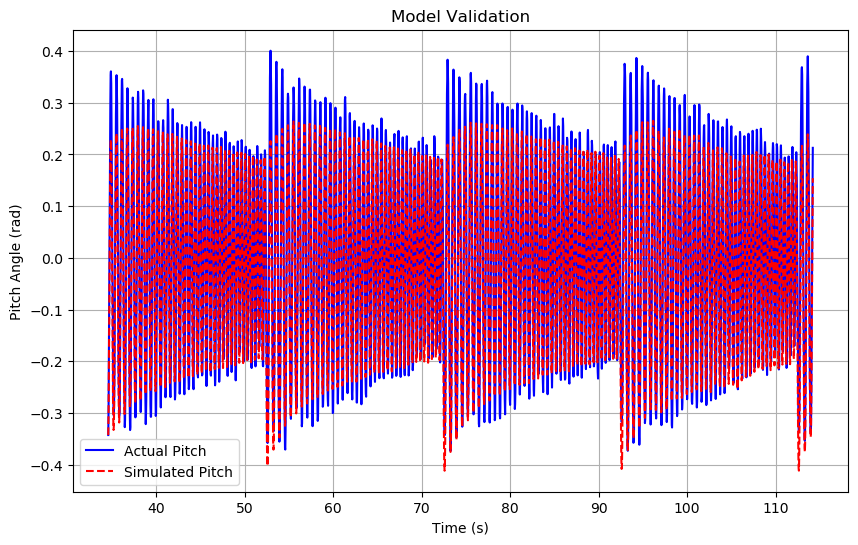

In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Load the CSV file
data = pd.read_csv('systemid.csv')

# Extract relevant columns
time = data['time'].values
pitch_cmd = data['pitch_cmd'].values
pitch_actual = data['pitch_actual'].values


def first_order_pitch_model(t, k_theta, tau_theta):
    """First-order system response for pitch."""
    theta_predicted = np.zeros_like(t)
    theta_predicted[0] = pitch_actual[0]  # Initial condition

    for i in range(1, len(t)):
        dt = t[i] - t[i - 1]
        theta_predicted[i] = theta_predicted[i - 1] + (dt / tau_theta) * (k_theta * pitch_cmd[i - 1] - theta_predicted[i - 1])
    
    return theta_predicted

# Perform curve fitting to estimate k_theta and tau_theta
params_pitch, _ = curve_fit(first_order_pitch_model, time, pitch_actual, p0=[1.0, 1.0])

# Extract estimated parameters
k_theta_estimated, tau_theta_estimated = params_pitch

print(f"Estimated Parameters:\nk_theta: {k_theta_estimated}, tau_theta: {tau_theta_estimated}")

# Simulate using estimated parameters
theta_simulated = first_order_pitch_model(time, k_theta_estimated, tau_theta_estimated)

# Plot results for validation
plt.figure(figsize=(10, 6))
plt.plot(time, pitch_actual, label='Actual Pitch', color='blue')
plt.plot(time, theta_simulated, label='Simulated Pitch', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Angle (rad)')
plt.legend()
plt.title('Model Validation')
plt.grid()
plt.show()

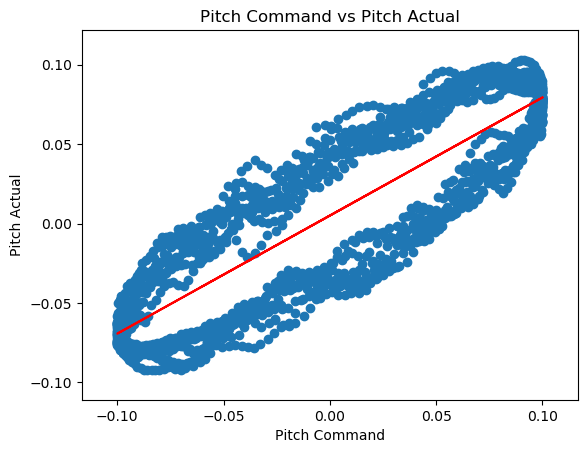

Pitch Actual = 0.7437070170717712*Pitch Command + 0.0050401709020736225


In [5]:
#fit a linear model to the data pitch cmd and pitch actual

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#fit a linear model to the data roll cmd and roll actual
data = np.genfromtxt(output_file, delimiter=',', skip_header=1)
x = data[:,3].reshape(-1,1)
y = data[:,4].reshape(-1,1)
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.xlabel('Pitch Command')
plt.ylabel('Pitch Actual')
plt.title('Pitch Command vs Pitch Actual')
plt.show()
#equation of the line
m = model.coef_[0][0]
c = model.intercept_[0]
print(f"Pitch Actual = {m}*Pitch Command + {c}")
